#### 数据集：Zachary‘s karate club network
图只有1个

每一个点有34维度特征

对每一个点做4分类


In [1]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}')
print('================================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub()
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [39]:
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


34x34====>M*F

M为样本个数，F为特征维度

一共有156的点，从source到target映射

y为标签

train_mask主要用于计算损失，能够标记有标签的点

In [3]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

前一个为0~34号点，后一位为该点与哪些点有关系

index稀疏表示的，并不是一个n*n的邻接矩阵

#### 可视化部分

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

# 绘制graph
def visualize_graphs(g, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(g, pos=nx.spring_layout(g, seed=42), with_labels=G.nodes, node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], c=color, s=140, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch:{epoch}, loss:{loss.item():.4f}', fontsize=16)
    plt.show()

#### 使用networkx可视化展示

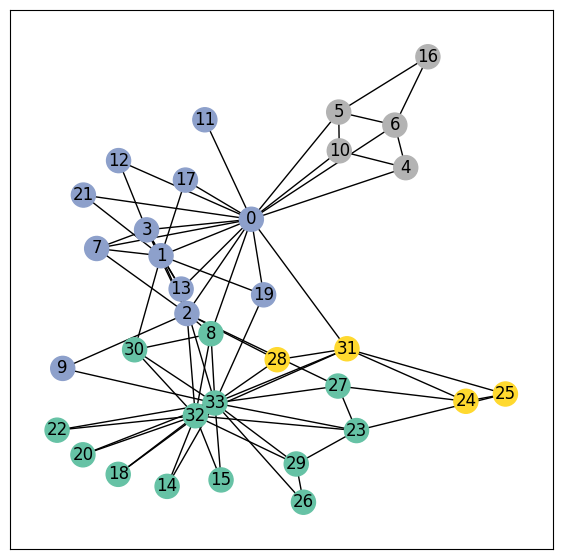

In [19]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graphs(G, color=data.y)


#### GCN网络定义

In [40]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        # 输入34个特征输出4个分类
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        # 最终产生中间结果：2维向量
        self.conv3 = GCNConv(4, 2)
        # 将2维向量进行4分类任务
        self.classifier = Linear(2, dataset.num_classes)    # 4

    # 前向传播
    def forward(self, x, edge_index):
        # 输入特征x与邻接矩阵edge_index
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        # 分类层
        out = self.classifier(h)
        return out,h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


### 输出特征展示

模型还没有训练，用随机画，观察最后输出的二位特征是什么样子

Embedding shape: [34, 2]


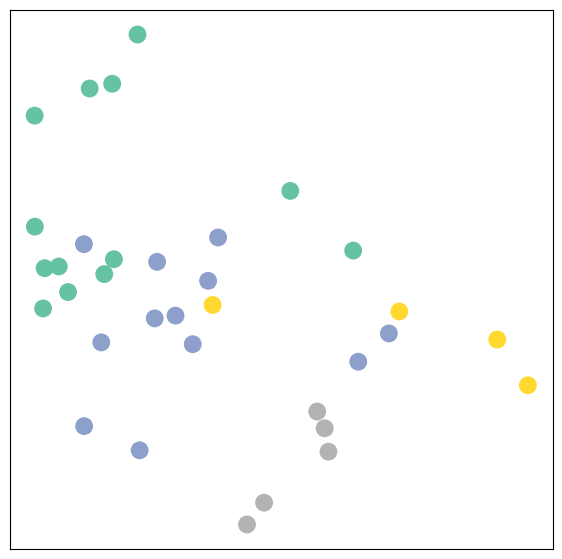

In [41]:
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

### 训练模型：semi-supervised

  0%|          | 0/401 [00:00<?, ?it/s]

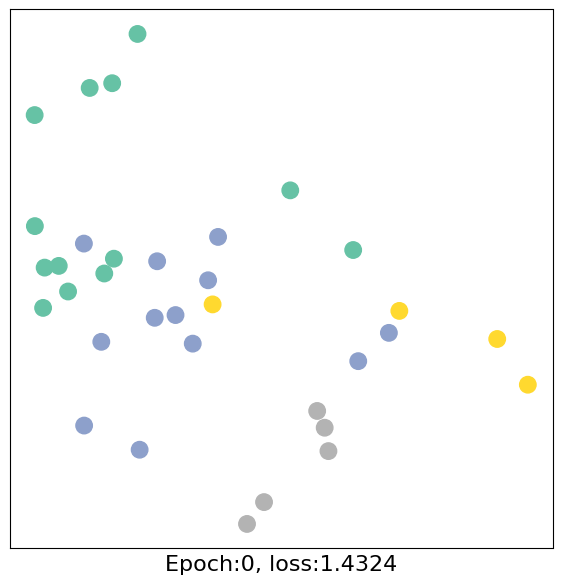

 24%|██▎       | 95/401 [00:00<00:01, 212.52it/s]

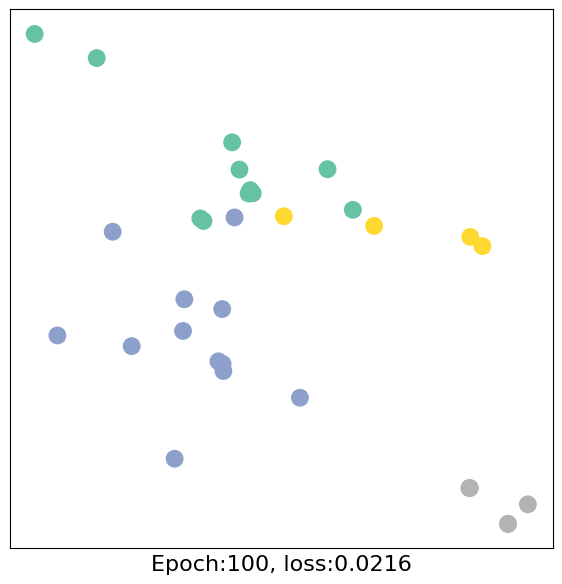

 47%|████▋     | 187/401 [00:01<00:01, 207.53it/s]

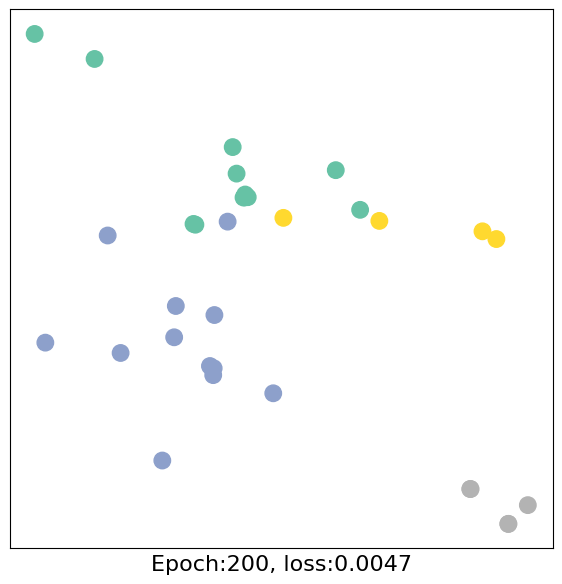

 73%|███████▎  | 291/401 [00:01<00:00, 176.83it/s]

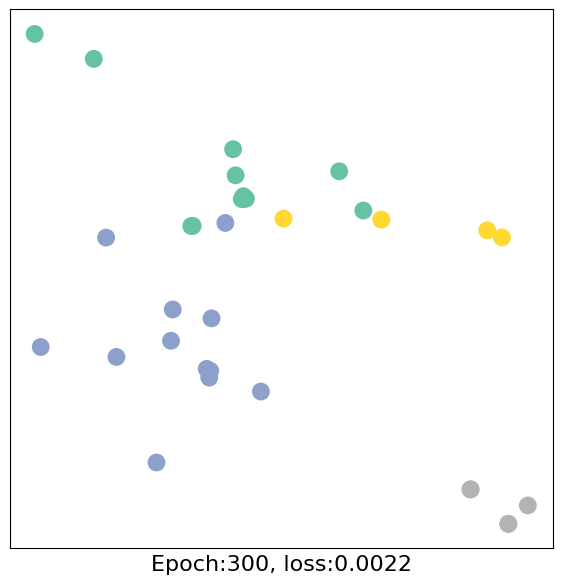

 95%|█████████▌| 381/401 [00:02<00:00, 191.98it/s]

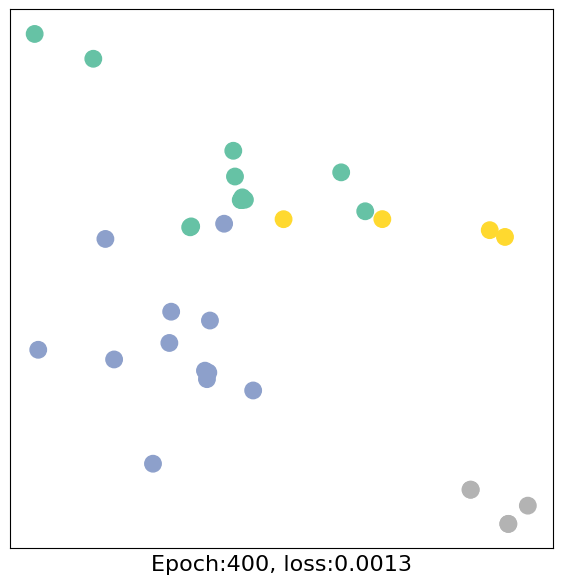

100%|██████████| 401/401 [00:02<00:00, 171.29it/s]


In [38]:
import time
from tqdm import *

model = GCN()
# 定义分类损失函数
criterion = torch.nn.CrossEntropyLoss()
# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    # 梯度清零
    optimizer.zero_grad()
    # 前向传播
    out, h = model(data.x, data.edge_index)
    # 计算损失；输出只看有mask=true点的输出，标签只看有mask=ture的标签
    # 半监督学习
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()
    return loss, h

for epoch in tqdm(range(401)):
    loss, h = train(data)
    # 每10个epoch画一个图
    if epoch % 100 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.01)